## Imports

In [83]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress
import numpy as np
import os
import math
import collections
from faraday_common import Observation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [84]:
data_file = 'data/faraday_data.xlsx'

In [85]:
full_df = pd.read_excel(data_file)
full_df

,Magnetic Field voltage (V),Magnetic Field Current (Amps),Magnetic Field (mT),Filter,Sample (cm),Min transmission angle,Unnamed: 6,Angle 1,Value 1,Angle 2,...,Value 6,Angle 7,Value 7,Angle 8,Value 8,Angle 9,Value 9,Unnamed: 25,Zero Field Angle,Intensity
0,0,0.00,1.73,Red,1.036,334,NaN,294,0.0315,304,...,0.00250,354,0.00760,364,0.0170,374,0.0300,NaN,335.274926,0.00101
1,0,0.00,1.73,Red,0.956,332,NaN,292,0.0426,302,...,0.00275,352,0.00672,362,0.0137,372,0.0214,NaN,338.287840,0.00269
2,0,0.00,1.73,Red,1.272,339,NaN,299,0.0223,309,...,0.00447,359,0.01080,369,0.0186,379,0.0275,NaN,335.957915,0.00211
3,0,0.00,1.73,Blue,1.272,332,NaN,292,0.0526,302,...,0.00696,352,0.01580,362,0.0300,372,0.0457,NaN,334.224460,0.00517
4,0,0.00,1.73,Blue,0.956,340,NaN,300,0.0548,310,...,0.01620,360,0.03240,370,0.0508,380,0.0646,NaN,336.576890,0.00729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,-30,-1.22,-230.54,Blue,1.272,346,NaN,306,0.0210,316,...,0.00360,366,0.00878,376,0.0157,386,0.0234,NaN,334.224460,0.01000
59,-30,-1.22,-230.54,Blue,1.036,313,NaN,273,0.0532,283,...,0.00499,333,0.01600,343,0.0310,353,0.0468,NaN,336.148007,0.01630
60,-30,-1.22,-230.54,Red,0.956,341,NaN,301,0.0230,311,...,0.00615,361,0.01290,371,0.0222,381,0.0313,NaN,338.287840,0.00293
61,-30,-1.22,-230.54,Red,1.272,340,NaN,300,0.0249,310,...,0.00202,360,0.00608,370,0.0118,380,0.0194,NaN,335.957915,0.00234


In [86]:
observation_arr = []
for i, row in full_df.iterrows():
    mag_field_volt, mag_field_curr, mag_field, filter, sample, min_trans_eye = row[0:6].values
    angles = [row[f"Angle {j}"] for j in range(1, 10)]
    intensities = [row[f"Value {j}"] for j in range(1, 10)]
    observation = Observation(mag_field, 
                              filter, 
                              sample, 
                              min_trans_eye, 
                              angles, 
                              intensities)
    observation_arr.append(observation)

## Method 1: Minimum eye transmissions versus Field

In [87]:
from faraday_common import findRanges, minEyeTransmission

In [88]:
minEyeTransmissionVersusMagneticField = minEyeTransmission(full_df)
anglesVFieldDict = minEyeTransmissionVersusMagneticField.transmissionAnglesVersusBField
print(anglesVFieldDict)

{'1.036_Red': [array([334, 339, 340, 347, 332, 330, 328], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '1.036_Blue': [array([337, 335, 332, 358, 334, 320, 313], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '1.036_Yellow': [array([335, 340, 346, 350, 331, 326, 320], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '0.956_Red': [array([332, 333, 331, 336, 331, 336, 341], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '0.956_Blue': [array([340, 336, 335, 337, 337, 337, 336], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '0.956_Yellow': [array([334, 335, 336, 338, 338, 339, 337], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54])], '1.272_Red': [array([339, 333, 337, 333, 338, 339, 340], dtype=int64), array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157

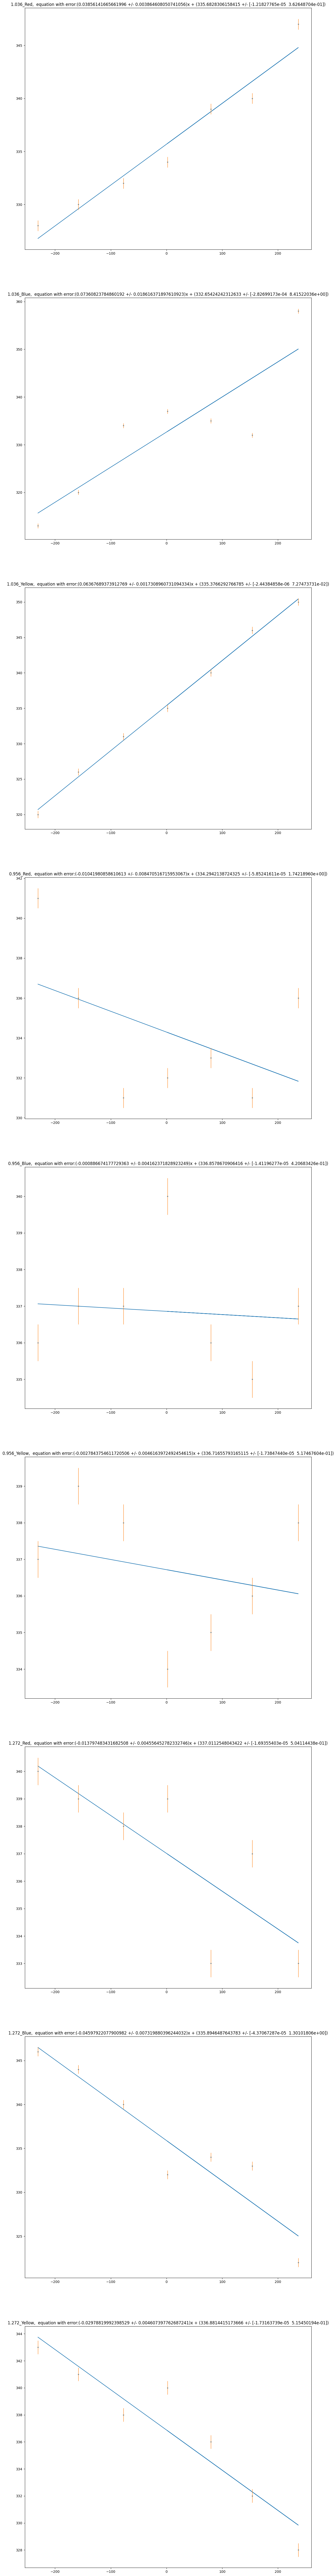

In [89]:
n = len(anglesVFieldDict)
berror = 0.01
aerror = 0.5
FIGSIZE = 15
fig, ax = plt.subplots(n, figsize = (FIGSIZE, FIGSIZE*n))
i = 0


def line(x, A, B):
    return A*x + B



for key, values in anglesVFieldDict.items():
    angle_vals = values[0]
    B_vals = values[1]


    Berror = np.ones(len(B_vals))*berror
    angleError = np.ones(len(angle_vals))*aerror

    popt, pcov = curve_fit(line,   B_vals, angle_vals)
    perr = np.sqrt(np.diag(pcov))

    ax[i].plot(B_vals, line(B_vals, popt[0], popt[1]))
    ax[i].scatter(B_vals, angle_vals, s=5)
    ax[i].errorbar(B_vals, angle_vals, xerr = Berror, yerr = angleError, linewidth = 0, elinewidth = 1)
    
    ax[i].set_title(f"{key},  equation with error:({popt[0]} +/- {perr[0]})x + ({popt[1]} +/- {pcov[1]})")

    i+=1
    

## Method 2: Malus curve fit at each B field

In [90]:
from faraday_common import SampleAndFilter
sample_and_filter_dict = collections.defaultdict(dict)

##Initialize with 0 field sample/filters
for observation in observation_arr[:9]:
    sample_and_filter_dict[observation.filter][observation.sample] = SampleAndFilter(observation.filter, observation.sample)

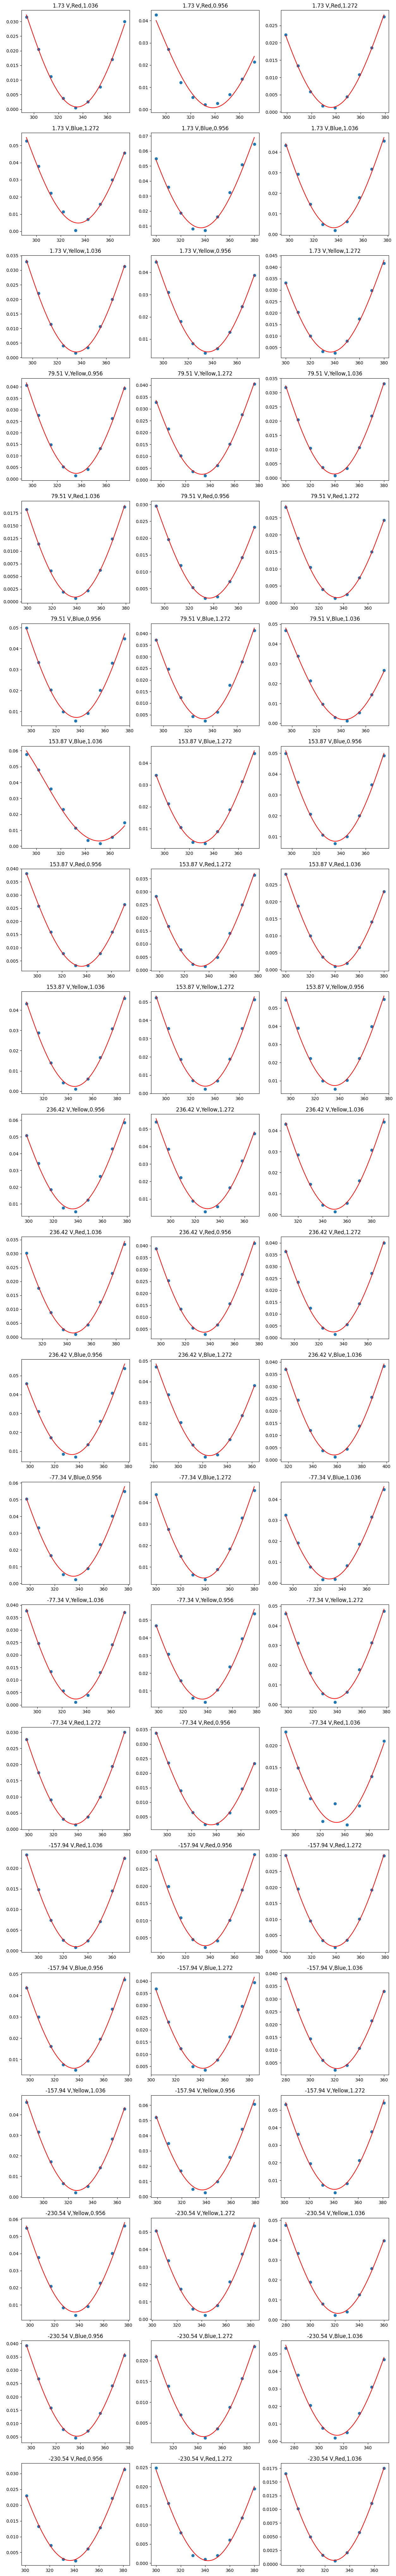

In [91]:
## Fit the 63 field/sample/filter combos
n_figures = 63
fig, axes = plt.subplots(n_figures // 3, 3, figsize = (15, 5 * n_figures // 3))
for i, ax in enumerate(axes.flatten()):
    observation = observation_arr[i]
    mf = MalusFit(observation)
    mf.plot_fit(ax)
    sample_and_filter = sample_and_filter_dict[observation.filter][observation.sample]
    sample_and_filter.mag_field_arr.append(observation.mag_field)
    sample_and_filter.angle_arr.append(mf.get_min_angle())

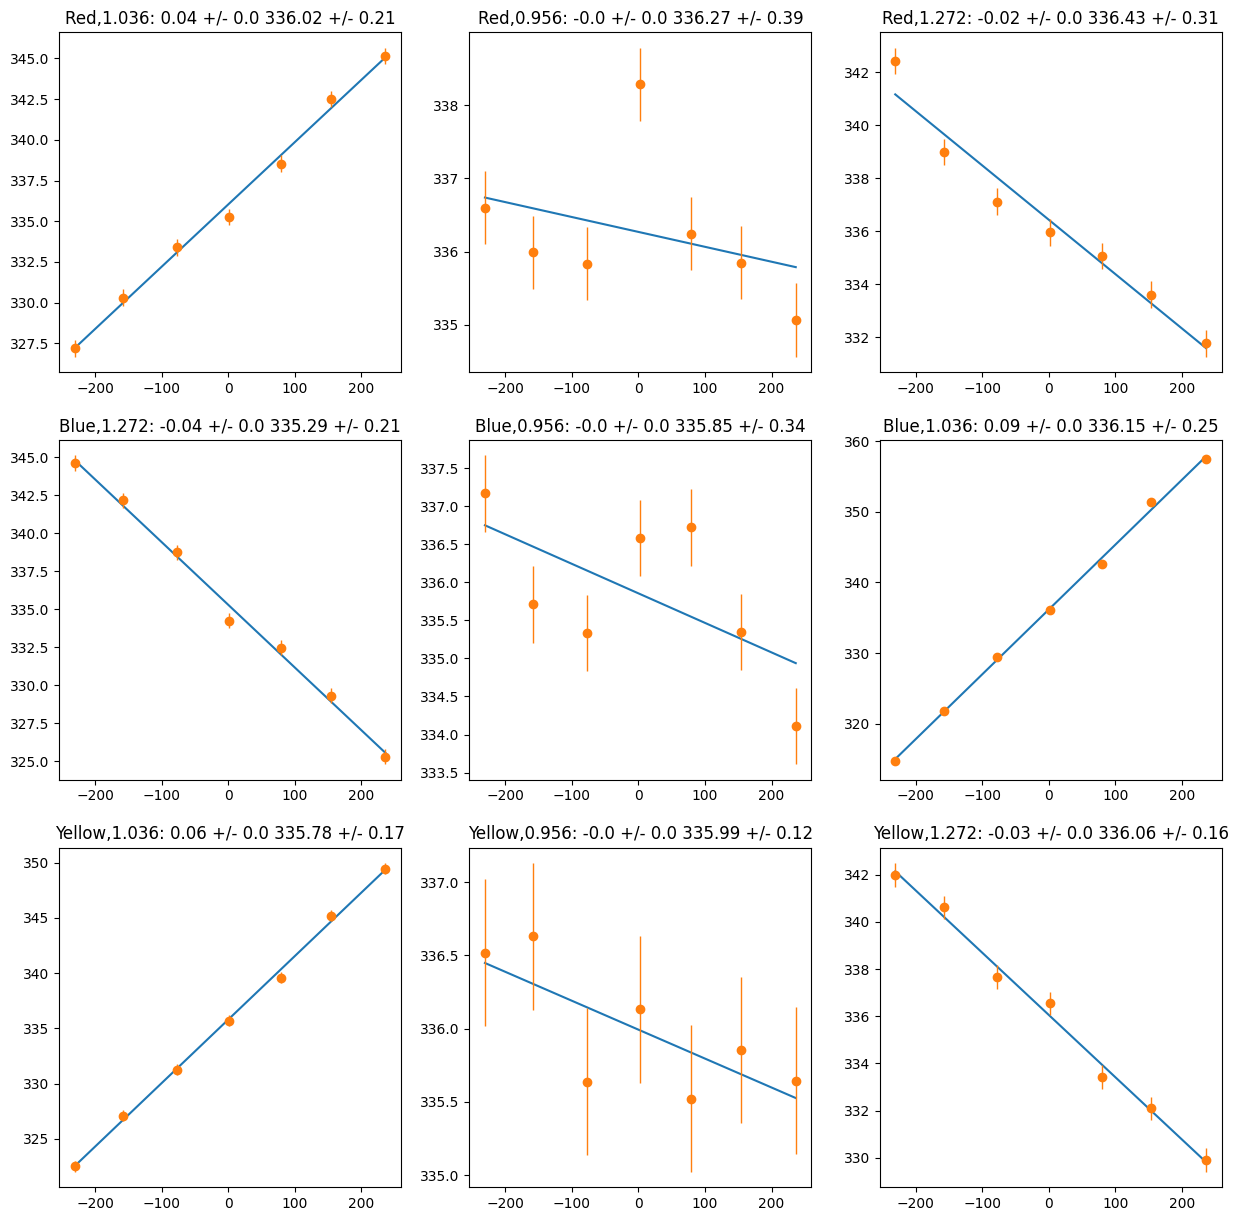

In [92]:
fig, axes = plt.subplots(3, 3, figsize = (15, 15))

for i, filter in enumerate(sample_and_filter_dict.keys()):
    for j, sample in enumerate(sample_and_filter_dict[filter].keys()):
        sample_and_filter = sample_and_filter_dict[filter][sample]
        sample_and_filter.fit()
        sample_and_filter.plot_fit(axes[i, j])

## Method 3: Zero Field Malus

In [94]:
from faraday_common import zeroFieldMalus

In [95]:
ZFM = zeroFieldMalus(full_df)
ZFMDict = ZFM.BvsIntensityZeroField
print(ZFMDict)

{'1.036_Red': [array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54]), array([0.00101 , 0.0012  , 0.00343 , 0.00299 , 0.000695, 0.001   ,
       0.00269 ]), array([335.27492589, 335.27492589, 335.27492589, 335.27492589,
       335.27492589, 335.27492589, 335.27492589])], '1.036_Blue': [array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54]), array([0.00105, 0.00289, 0.00748, 0.013  , 0.00219, 0.00965, 0.0163 ]), array([336.14800699, 336.14800699, 336.14800699, 336.14800699,
       336.14800699, 336.14800699, 336.14800699])], '1.036_Yellow': [array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54]), array([0.00101, 0.00178, 0.00421, 0.00658, 0.00189, 0.00379, 0.00427]), array([335.69612907, 335.69612907, 335.69612907, 335.69612907,
       335.69612907, 335.69612907, 335.69612907])], '0.956_Red': [array([   1.73,   79.51,  153.87,  236.42,  -77.34, -157.94, -230.54]), array([0.00269 , 0.00207 , 0.00328 , 0.0021  , 0.00157 , 0.000992,
       0.

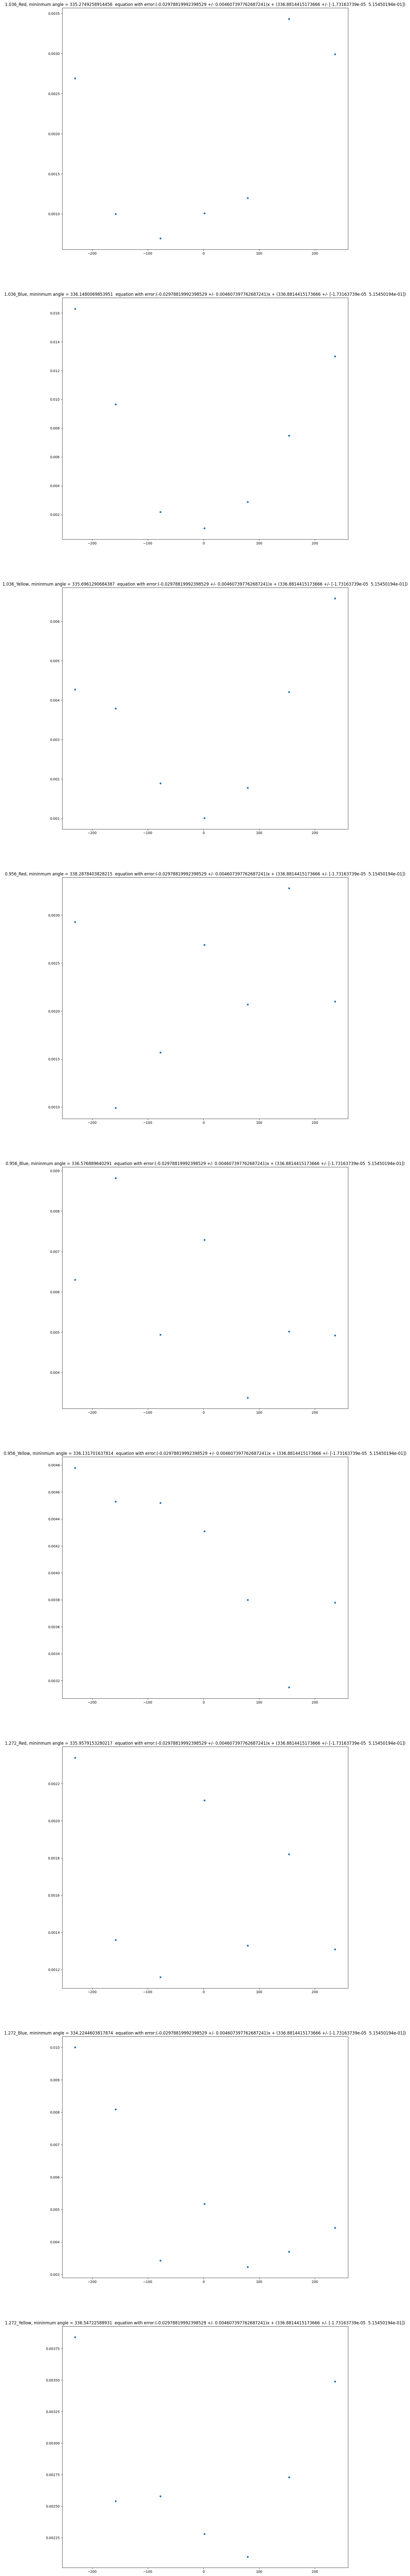

In [96]:
n = len(ZFMDict)
berror = 0.01
aerror = 0.5
FIGSIZE = 15
fig, ax = plt.subplots(n, figsize = (FIGSIZE, FIGSIZE*n))
i = 0


def line(x, A, B):
    return A*x + B



for key, values in ZFMDict.items():
    angle_vals = values[1]
    B_vals = values[0]
    minAngle = values[2][0]
    # print(angle_vals)
    # print(B_vals)
# plt.plot(xdata, func(xdata, *popt), 'r-',
# ...          label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))


    # Berror = np.ones(len(B_vals))*berror
    # angleError = np.ones(len(angle_vals))*aerror

    # popt, pcov = curve_fit(line,   B_vals, angle_vals)
    # perr = np.sqrt(np.diag(pcov))

    # ax[i].plot(B_vals, line(B_vals, popt[0], popt[1]))
    ax[i].scatter(B_vals, angle_vals, s=20)
    #ax[i].errorbar(B_vals, angle_vals, xerr = Berror, yerr = angleError, linewidth = 0, elinewidth = 1)
    
    ax[i].set_title(f"{key}, mininmum angle = {minAngle}  equation with error:({popt[0]} +/- {perr[0]})x + ({popt[1]} +/- {pcov[1]})")

    i+=1
    